In [2]:
!pip install numpy
!pip install matplotlib

    100% |████████████████████████████████| 11.5MB 135kB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 3.0MB 390kB/s ta 0:00:011
    100% |████████████████████████████████| 1.1MB 1.0MB/s ta 0:00:01


In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
class AMM:
    sigma, eta = 0.2, 0.8
    
    def __init__(self, init_a, init_b, init_y):
        self.init_a = init_a
        self.init_b = init_b
        self.init_y = init_y
        
    def mu_function(self, a, b, y):
        sigma, eta = self.sigma, self.eta
        return (a ** (1 - sigma) + b ** (1 - sigma)) ** ((1 - eta) / (1 - sigma)) + y ** (1 - eta)
    
    def get_delta_a(self, delta_y):
        a, b, y = self.init_a, self.init_b, self.init_y
        sigma, eta = self.sigma, self.eta
        
        mu = self.mu_function(a, b, y)
        
        return a - ((mu - (y + delta_y) ** (1 - eta)) ** ((1 - sigma) / (1 - eta)) - b ** (1 - sigma)) ** (1 / (1 - sigma)) 
    
    def get_delta_y(self, delta_a):
        a, b, y = self.init_a, self.init_b, self.init_y
        sigma, eta = self.sigma, self.eta
        
        mu = self.mu_function(a, b, y)
        
        return -(mu - ((a + delta_a) ** (1 - sigma) + b ** (1 - sigma)) ** ((1 - eta) / (1 - sigma))) ** (1 / (1 - eta)) + y
   
    def get_delta_b(self, delta_a):
        a, b, y = self.init_a, self.init_b, self.init_y
        sigma, eta = self.sigma, self.eta
        
        mu = self.mu_function(a, b, y)
        
        return -((mu - y ** (1 - eta)) ** ((1 - sigma) / (1 - eta)) - (a + delta_a) ** (1 - sigma)) ** (1 / (1 - sigma)) + b

<IPython.core.display.Javascript object>


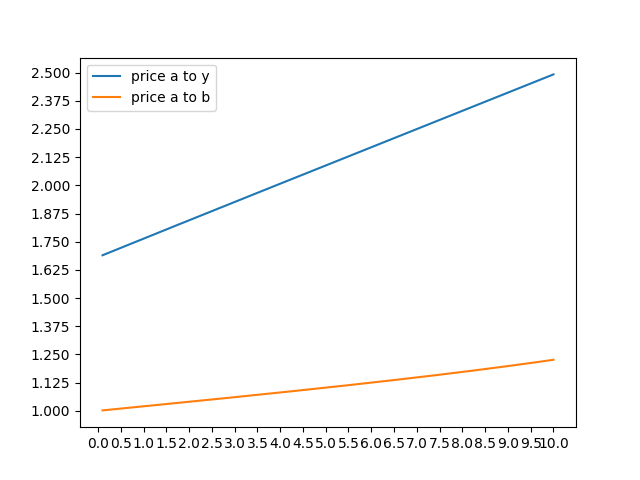

In [3]:
amm = AMM(10, 10, 10)
x_series = np.linspace(0.1, 10, 1000)

a_y = [amm.get_delta_a(x) for x in x_series]
y_a = [amm.get_delta_y(x) for x in x_series]
b_a = [amm.get_delta_b(x) for x in x_series]

plt.figure()
plt.rcParams["figure.figsize"] = (10,8)
plt.yticks(np.linspace(0, 3, 25))
plt.xticks(np.linspace(0, 10, 21))
plt.plot(x_series, x_series/y_a)
plt.plot(x_series, x_series/b_a)
plt.legend(['price a to y', 'price a to b'])
plt.savefig('price_chart.png')

## Introduction

This is the `constant curve`:
   $$ \Lambda(a, b, y) = ((a^{1-\sigma} + b^{1-\sigma})^{\frac{1}{1-\sigma}})^{1-\eta} + y^{1-\eta} $$

If the buy amount is enough small, we can assume the price of `a` to `b` as $\frac{\partial a}{\partial b}$ .

From the expression (9) in the paper, $\frac{\partial a}{\partial b} = (\frac{a}{b}) ^ {\sigma}$

It means the price of `a` to `b` is related to the ratio of token `a` amount to token `b` amount. Assume that $b = a * r$

Then `constant curve` as follows:
    $$ \Lambda(a, y) = ((1 + r^{1-\sigma})^{\frac{1}{1-\sigma}})^{1-\eta} * a^{1-\eta} + y^{1-\eta} $$
    $$ c = ((1 + r^{1-\sigma})^{\frac{1}{1-\sigma}})^{1-\eta} $$
    $$ \Lambda(a, y) = c * a^{1-\eta} + y^{1-\eta} $$

In the similar way, the price of `a` to `y` would be $\frac{\partial a}{\partial y}$
    $$ \frac{\partial a}{\partial y} = \frac{\frac{\partial \Lambda}{\partial y}}{\frac{\partial \Lambda}{\partial a}} = \frac{(1 - \eta) * y ^ {-\eta}}{(1 - \eta) * (a ^ {1 - \sigma} + b ^ {1 - \sigma}) ^ {\frac{\sigma - \eta}{1 - \sigma}} * a ^ {-\sigma}} = k * (\frac{a}{y}) ^ \eta $$
    $$ k = {(1 + r ^ {1 - \sigma}) ^ {\frac{\eta - \sigma}{1 - \sigma}}} $$
Here considering `c` is the contant, the price of `a` to `y` is also related to the ratio of token `a` amount to token `y` amount.

It means we should keep the ratio between all token amounts to keep the price.

You can check the price change of 1 unit according the initial amount. 

<IPython.core.display.Javascript object>


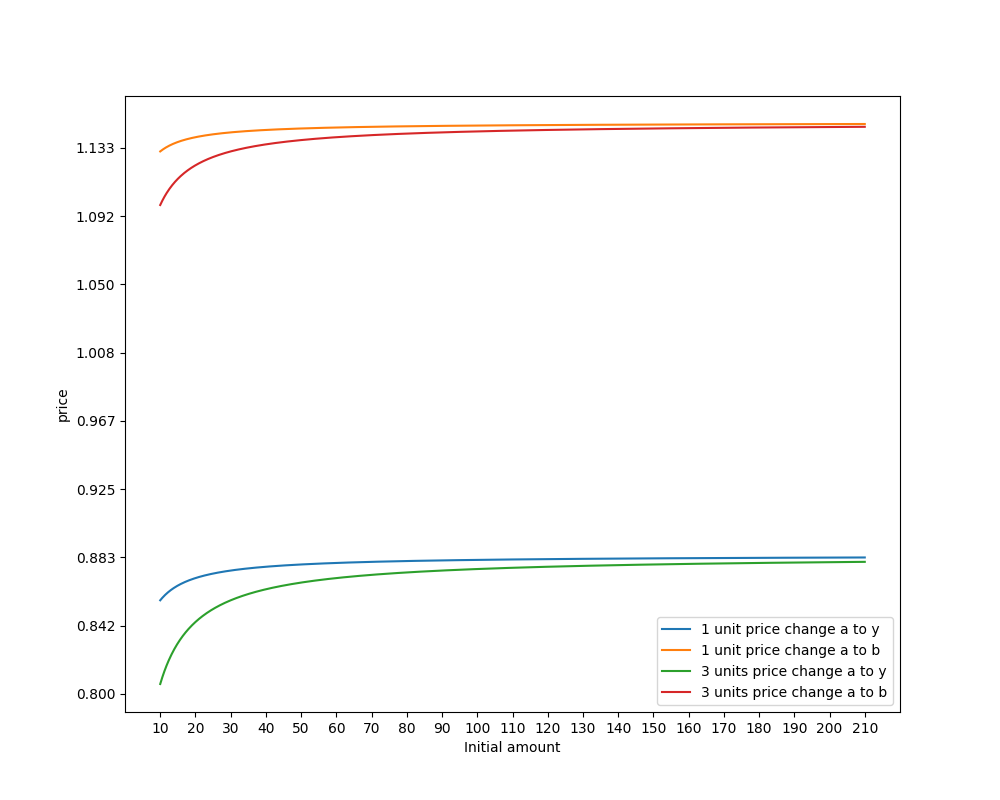

In [11]:
x_series = np.linspace(10, 210, 1000)

a_y = [AMM(x, x * 2, x * 3).get_delta_a(1) for x in x_series]
b_a = [AMM(x, x * 2, x * 3).get_delta_b(1) for x in x_series]

a_y_3 = [AMM(x, x * 2, x * 3).get_delta_a(3) for x in x_series]
b_a_3 = [AMM(x, x * 2, x * 3).get_delta_b(3) for x in x_series]


plt.figure()
plt.rcParams["figure.figsize"] = (10,8)
plt.yticks(np.linspace(0.8, 1.8, 25))
plt.xticks(np.linspace(10, 210, 21))
plt.xlabel("Initial amount")
plt.ylabel("price")
plt.plot(x_series, a_y)
plt.plot(x_series, b_a)
plt.plot(x_series, np.array(a_y_3) / 3)
plt.plot(x_series, np.array(b_a_3) / 3)
plt.legend(['1 unit price change a to y', '1 unit price change a to b', '3 units price change a to y', '3 units price change a to b'])
plt.savefig('price_chart.png')

## Liquidity provide mechanism

1. we should keep the ratio between all token amounts.
2. we can manage the amount of each token that add to pool to keep the raito or make more close to the target ratio. 
    
    Calculate the target ratio by the expotential moviing average of the ratio history or the global price of token from oracle.

In [13]:
x = 10000
a_to_y = AMM(x, x, x).get_delta_a(1)
print(a_to_y, 2 ** ((0.8 - 0.2) / (1 - 0.2)))

1.6816548587667057 1.6817928305074292
